# Assignment 3
---
Shreya Laddha - 180070054
--
Drive Folder Link for files and folders used in this notebook - https://drive.google.com/drive/folders/1le0OKmU8LY1CjJ-KrS4epeetrftDtJ9W?usp=sharing

Colab Notebook link - https://colab.research.google.com/drive/1sV4W4XTF9KKYeOMQamdstHjj941aO4hl?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
% cd '/content/drive/MyDrive/EE679_A3'

/content/drive/MyDrive/EE679_A3


## Libraries

In [2]:
!pip install hmmlearn

     |████████████████████████████████| 374 kB 7.2 MB/s 


In [26]:
import librosa
import numpy as np
import os
import pickle
import hmmlearn
import itertools

from hmmlearn import hmm
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io.wavfile import write
import matplotlib.pyplot as plt
import math
import scipy.misc
from scipy.io.wavfile import read
import soundfile as sf
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
from scipy.io import wavfile
%matplotlib inline

## Training data creation 

In [5]:
def end_pointing(filepath):

    #-------------------Slicing / extracting frames-------------------------------#
    # 20ms window frame; 50 % overlap; so 10ms*16khz = 160 samples (these will be points where sliced)

    audio_time ,sampling_rate = librosa.load(filepath)
    audio_len = np.int(len(audio_time)) #length of signal - initial
    sliced_frames = []
    idx = 0 #index to keep track

    while idx<= (audio_len/160)-2: #-2 done to remove last and first half windows
        frame = audio_time[idx*160 : (idx+2)*160]
        idx += 1
        sliced_frames.append(frame)
        
    ### Finding the start and end; 
    start = 0 
    current = 0
    end = np.int(len(sliced_frames))-1

    # to keep a track if index has been updated already and noise has been eliminated from start and end
    updated = False
    noise = True
    
    #iterating over all frames one by one
    while current < np.int(len(sliced_frames)):
        
        hamming = np.hamming(320) # 20 ms size of HAMMING window with 16kHz sampling rate == 320 samples

        ## using energy calculation method
        energy = np.matmul(sliced_frames[current]*hamming , sliced_frames[current]*hamming) #energy = x^2
        
        if(energy > 0.004): #updating start point
            if(noise == True):
                noise = False
                if updated == False:
                    updated = True
                    start = current
                    break
        current = current+1
    
    updated = False
    noise = True

    current = np.int(len(sliced_frames))-1
    #iterating over all frames one by one
    while current > 0:
        hamming = np.hamming(320) # 20 ms size of HAMMING window with 16kHz sampling rate == 320 samples

        ## using energy calculation method
        energy = np.matmul(sliced_frames[current]*hamming , sliced_frames[current]*hamming) #energy = x^2

        if(energy > 0.004): #updating end point
            if(noise == True):
                noise = False
                if updated == False:
                    updated = True
                    end = current
                    break
        current -= 1

    # print(np.int(len(sliced_frames)), "start" ,start , "end " ,end)    

    end_pointed = np.array(audio_time[start*160 : (end+2)*160])
    return end_pointed, sampling_rate


In [22]:
## end pointing all files

for word in os.listdir('Commands Dataset/train'): 
    print(word)
    for sample in os.listdir('Commands Dataset/train/'+ word): 
        # print(word, sample)
        endp , samp = end_pointing('Commands Dataset/train/'+ word + '/' + sample)
        # threshold to ignore only empty files or very small noise files
        if np.int(len(endp)) >10000 :
            sf.write('Commands Dataset/endpointed_train/'+ word + '/' + sample, endp, samp)


down
left
no
go
right
off
on
stop
yes
up


In [6]:
### pre emphasis -- from assignment 2

def pre_emphasis(x):
    alpha = 0.95;
    y = np.zeros(len(x));
    for i in range(1, len(x)):
        y[i] = x[i] - alpha*x[i-1];
    return y

def pre_emp(filepath):
    input , sampling_rate = librosa.load(filepath)
    y = pre_emphasis(input)
    return y, sampling_rate


In [25]:
for word in os.listdir('Commands Dataset/endpointed_train'): 
    print(word)
    for sample in os.listdir('Commands Dataset/endpointed_train/'+ word): 
        # print(word, sample)
        pre_emph, samp = pre_emp('Commands Dataset/endpointed_train/'+ word + '/' + sample)
        sf.write('Commands Dataset/preemp_train/'+ word + '/' + sample, pre_emph, samp)
    

on
up
yes
stop


In [7]:
## MFCC feature extraction

def mfcc_features(filepath):
    audio , samp_rate = librosa.load(filepath)
    c = librosa.feature.mfcc(y=audio, sr=samp_rate, norm='ortho', n_mfcc=13, dct_type=2, S=None)
    delta = librosa.feature.delta(c, order=1, mode = 'nearest')
    delta2 = librosa.feature.delta(c, order=2, mode = 'nearest')

    mfcc = np.concatenate((c, delta , delta2 ), axis=0)
    
    return mfcc

def mfcc_features_sample(audio, samp_rate):
    # audio , samp_rate = librosa.load(filepath)
    c = librosa.feature.mfcc(y=audio, sr=samp_rate, norm='ortho', n_mfcc=13, dct_type=2, S=None)
    delta = librosa.feature.delta(c, order=1, mode = 'nearest')
    delta2 = librosa.feature.delta(c, order=2, mode = 'nearest')

    mfcc = np.concatenate((c, delta , delta2 ), axis=0)
    
    return mfcc

In [11]:
## saving training data .

training = {}
for word in os.listdir('Commands Dataset/preemp_train'):
    print(word)
    for sample in os.listdir('Commands Dataset/preemp_train/'+word):
        # true_word = word
        p = 'Commands Dataset/preemp_train/'+word + '/' + sample
        # print(p)
        mfcc = mfcc_features(p).T
        
        if word not in training.keys():
            training[word] = [mfcc]
            # training[word].append(mfcc)
        else:
            # y = training[word]
            # y.append(mfcc)
            training[word].append(mfcc)

with open("preemp_train_data.pkl", "wb") as file:
    pickle.dump(training , file)

down
up
go
stop
on
off
no
yes
left
right


## Test data creation

In [ ]:
### task A data 

test_clean = {}
for word in os.listdir('Commands Dataset/test_clean'):
    print(word)
    for sample in os.listdir('Commands Dataset/test_clean/'+word):
        p = 'Commands Dataset/test_clean/'+word + '/' + sample
        end_pointed, samp_rate  = end_pointing(p)
        pre_emped = pre_emphasis(end_pointed)  
        mfcc = mfcc_features_sample(pre_emped,samp_rate).T
        if word not in test_clean.keys():
            test_clean[word] = [mfcc]
        else:
            test_clean[word].append(mfcc)

with open("test_task_A.pkl", "wb") as file:
    pickle.dump(test_clean , file)

In [ ]:
## task B data
test_noisy = {}
for word in os.listdir('Commands Dataset/test_noisy'):
    print(word)
    for sample in os.listdir('Commands Dataset/test_noisy/'+word):
        p = 'Commands Dataset/test_clean/'+word + '/' + sample
        end_pointed, samp_rate  = end_pointing(p)
        pre_emped = pre_emphasis(end_pointed)  
        mfcc = mfcc_features_sample(pre_emped,samp_rate).T
        if word not in test_noisy.keys():
            test_noisy[word] = [mfcc]
        else:
            test_noisy[word].append(mfcc)

with open("test_task_B.pkl", "wb") as file:
    pickle.dump(test_noisy , file)

## Training data creation (with additive noise)

In [ ]:
def add_noise(speech, noise):

    numSamples = len(speech)

    # extracting a segment of noise from a random position
    i = np.random.choice(len(noise) - numSamples)
    noise_segment = noise[i:i+numSamples] #length = len of speech signal

    # PCM values (-32768 to 32767) to floats (range -1.0 to 1.0)
    speech = speech/32768
    noise_segment = noise_segment/32768

    #normalizing the noise
    speech_energy = np.sum(speech**2)
    noise_energy = np.sum(noise_segment**2)
    noise_segment = noise_segment*(np.sqrt(speech_energy/(10*noise_energy))) #10db snr noise

    #adding to speech signal
    speech = speech + noise_segment

    #equating energy to raw speech
    new_energy = np.sum(speech**2)
    speech = speech*(np.sqrt(speech_energy/new_energy))

    #converting back to PCM
    speech = speech*32767
    speech = speech.astype(np.int16)
    
    return speech

In [ ]:
## Adding pink noise
noisefile = 'Commands Dataset/_background_noise_/pink_noise.wav'
samp_rate, noise = wavfile.read(noisefile)

for word in os.listdir('Commands Dataset/preemp_train'): 
    print(word)
    for sample in os.listdir('Commands Dataset/preemp_train/'+ word): 
        sampFreq, speech = wavfile.read('Commands Dataset/preemp_train/'+ word+ '/' + sample)
        output = add_noise(speech , noise)
        outputfile ='Commands Dataset/train_pink_noise/'+ word + '/' + sample 
        wavfile.write(outputfile, sampFreq, output)

In [ ]:
 ## Adding white noise
noisefile = 'Commands Dataset/_background_noise_/white_noise.wav'
samp_rate, noise = wavfile.read(noisefile)

for word in os.listdir('Commands Dataset/preemp_train'): 
    print(word)
    for sample in os.listdir('Commands Dataset/preemp_train/'+ word): 
        sampFreq, speech = wavfile.read('Commands Dataset/preemp_train/'+ word+ '/' + sample)
        output = add_noise(speech , noise)
        outputfile ='Commands Dataset/train_white_noise/'+ word + '/' + sample 
        wavfile.write(outputfile, sampFreq, speech)

In [ ]:
##  saving pink noise training data .

training = {}
for word in os.listdir('Commands Dataset/train_pink_noise'):
    print(word)
    for sample in os.listdir('Commands Dataset/train_pink_noise/'+word):
        p = 'Commands Dataset/train_pink_noise/'+word + '/' + sample
        mfcc = mfcc_features(p).T
        if word not in training.keys():
            training[word] = [mfcc]
        else:
            training[word].append(mfcc)

with open("training_pink_noise.pkl", "wb") as file:
    pickle.dump(training , file)

In [ ]:
##  saving white noise training data

training = {}
for word in os.listdir('Commands Dataset/train_white_noise'):
    print(word)
    for sample in os.listdir('Commands Dataset/train_white_noise/'+word):
        p = 'Commands Dataset/train_white_noise/'+word + '/' + sample
        mfcc = mfcc_features(p).T
        
        if word not in training.keys():
            training[word] = [mfcc]
        else:
            training[word].append(mfcc)

with open("training_white_noise.pkl", "wb") as file:
    pickle.dump(training , file)

## Training GMM and Gaussian and saving models

Keep changing the parameters and the training data for different permutations

In [3]:
# Loading train data
data_file  =  open('preemp_train_data.pkl', 'rb')
training = pickle.load(data_file)
data_file.close()

In [ ]:
# Loading white noise train data
data_file  =  open('training_white_noise.pkl', 'rb')
training = pickle.load(data_file)
data_file.close()

In [ ]:
# Loading pink noise train data
data_file  =  open('training_pink_noise.pkl', 'rb')
training = pickle.load(data_file)
data_file.close()

In [4]:
# training -- GMMHMM
trained_model = {}
hmm_states = 16 

for word in training.keys():
    print(word)
    model = hmm.GMMHMM(n_components=hmm_states, covariance_type='diag', n_mix=10, n_iter=10 , verbose=False,  )
    ## collecting the features of each word to train 
    current_data = training[word]

    # since the number of frames are different in each sample
    size = np.zeros([len(current_data), ], dtype=np.int)
    for i in range(np.int(len(current_data))):
        size[i] = current_data[i].shape[0]
    
    current_data = np.vstack(current_data)
    #### this fit() trains the model
    model.fit(current_data, lengths=size)
    trained_model[word] = model

with open("trained_GMM_16_mix10.pkl", "wb") as file:
    pickle.dump(trained_model, file)

down
up
go
stop
on
off
no
yes
left
right


In [ ]:
# Training --  GaussianHMM
trained_model = {}
hmm_states = 10

for true_word in training.keys():
    print(word)
    model = hmm.GaussianHMM(n_components = hmm_states, covariance_type='full', n_iter=10)
    
    ## collecting the features of each word to train 
    current_data = training[word]

    # since the number of frames are different in each sample
    size = np.zeros([len(current_data), ], dtype=np.int)
    for i in range(np.int(len(current_data))):
        size[i] = current_data[i].shape[0]
    
    current_data = np.vstack(current_data)
    #### this fit() trains the model
    model.fit(current_data, lengths=size)
    
    trained_model[true_word] = model
    
with open("trained_Gaussian.pkl", "wb") as file:
    pickle.dump(trained_model, file)

## Test data creation for model output

In [13]:
testA_model_file  =  open('test_task_A.pkl', 'rb')
testingA = pickle.load(testA_model_file)
testA_model_file.close()

testB_model_file  =  open('test_task_B.pkl', 'rb')
testingB = pickle.load(testB_model_file)
testB_model_file.close()


In [14]:
# making the input featurs and output labels of test data  

x_testA = []
y_testA = []
for a in testingA.keys():
    feature = testingA[a]
    l = np.int(len(feature))
    for t  in range(l):
        y_testA.append(a)
        x_testA.append(feature[t])

x_testB = []
y_testB = []
for a in testingB.keys():
    feature = testingB[a]
    l = np.int(len(feature))
    for t  in range(l):
        y_testB.append(a)
        x_testB.append(feature[t])

with open("xtestA.pkl", "wb") as file:
    pickle.dump(x_testA, file)
  
with open("xtestB.pkl", "wb") as file:
    pickle.dump(x_testB, file)

with open("ytestA.pkl", "wb") as file:
    pickle.dump(y_testA, file)
  
with open("ytestB.pkl", "wb") as file:
    pickle.dump(y_testB, file)

print(len(x_testA), len(x_testB))

done test data creation
2567 2567


## Predictions

### Functions for calculation

In [9]:
# ############ prediction function for given input and trained model

def prediction(test_data, trained):
    predicted_label = []
    words = []
    score_values = []
    for k in trained.keys():
        score_values.append(trained[k].score(test_data))
        words.append(k)
    predicted_label.append(score_values.index(max(score_values)))
    return words[predicted_label[0]]

In [10]:
## loading test data
trained_model_file  =  open('xtestA.pkl', 'rb')
x_testA = pickle.load(trained_model_file)
trained_model_file.close()


trained_model_file  =  open('xtestB.pkl', 'rb')
x_testB = pickle.load(trained_model_file)
trained_model_file.close()


trained_model_file  =  open('ytestA.pkl', 'rb')
y_testA = pickle.load(trained_model_file)
trained_model_file.close()

trained_model_file  =  open('ytestB.pkl', 'rb')
y_testB = pickle.load(trained_model_file)
trained_model_file.close()

In [23]:
 # returns predicted values
def return_ypred(filepath):
  hmm_model_file  =  open(filepath, 'rb')
  trained_model_hmm = pickle.load(hmm_model_file)
  hmm_model_file.close()

  n = 2567 # len(x_testA)
  pred_test = []

  for i in range(n):
    y_pred = prediction(x_testA[i],trained_model_hmm )
    pred_test.append(y_pred)


  pred_testB = []

  for i in range(n):
    y_pred = prediction(x_testB[i],trained_model_hmm )
    pred_testB.append(y_pred)

  return pred_test, pred_testB

In [60]:
# returns accuracy and confusion matrix for bothh tasks
def accuracy_cm(pred_test, pred_testB, data_type, states, mix, iter, model):

  ## Task A
  cm = confusion_matrix(y_testA, pred_test)
  accuracy = sum(np.diag(cm)) / (sum(sum(cm)))

  m = data_type+'-Train '+ model+' ' +states + '-states '+ mix+'-Mix '+ iter+'-iter' 
  print(m)
  print('Task A Accuracy = ',accuracy*100,'%')

  title='Confusion matrix -- Clean test Data'
  classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
  
  cmap=plt.cm.Blues

  plt.subplot(1,2,1)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('figures/TaskA_'+m+'.png')
  plt.autoscale(enable=True, axis='x', tight=True)
  plt.show()

  ## Task B
  cm = confusion_matrix(y_testB, pred_testB)
  accuracy = sum(np.diag(cm)) / (sum(sum(cm)))
  print('Task B Accuracy = ',accuracy*100,'%')

  title='Confusion matrix -- Noisy test Data'
  classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
  
  cmap=plt.cm.Blues

  plt.subplot(1,2,2)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  thresh = cm.max() / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('figures/TaskB_'+m+'.png', dpi = 200)
  plt.show()
  
  return

### For clean train data

Clean-Train GMM 6-states 1-Mix 10-iter
Task A Accuracy =  80.21036229061161 %


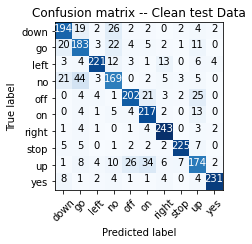

Task B Accuracy =  57.26529022204908 %


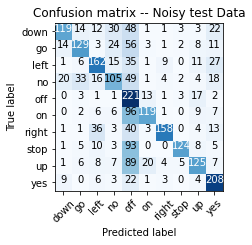

In [35]:
pred_test, pred_testB = return_ypred('trained_GMM_6.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '6', '1', '10', 'GMM')

Clean-Train GMM 8-states 1-Mix 10-iter
Task A Accuracy =  80.2493182703545 %


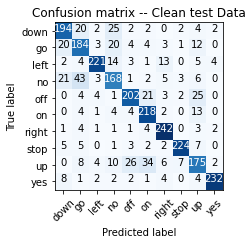

Task B Accuracy =  56.87573042462017 %


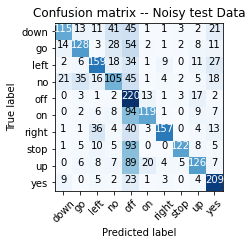

In [36]:
pred_test, pred_testB = return_ypred('trained_GMM_8.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '8', '1', '10', 'GMM')

Clean-Train GMM 10-states 1-Mix 10-iter
Task A Accuracy =  84.69029996104402 %


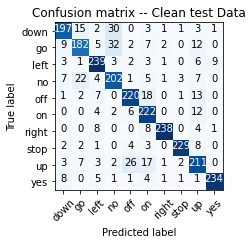

Task B Accuracy =  60.45968056096611 %


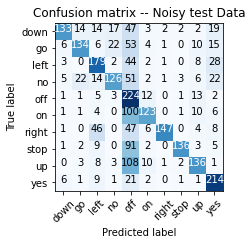

In [37]:
pred_test, pred_testB = return_ypred('trained_GMM_10.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '10', '1', '10', 'GMM')

Clean-Train GMM 10-states 10-Mix 10-iter
Task A Accuracy =  92.55940786910791 %


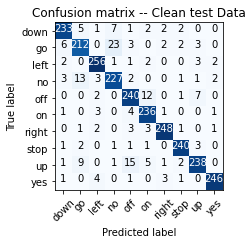

Task B Accuracy =  71.9906505648617 %


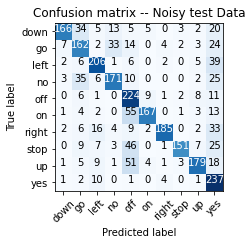

In [39]:
pred_test, pred_testB = return_ypred('trained_GMM_10_mix10.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '10', '10', '10', 'GMM')

Clean-Train GMM 10-states 15-Mix 20-iter
Task A Accuracy =  93.92286716010908 %


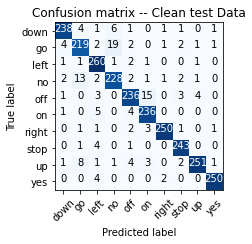

Task B Accuracy =  73.39306583560577 %


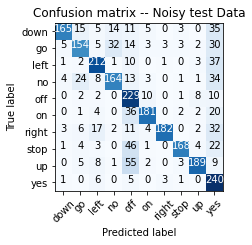

In [40]:
pred_test, pred_testB = return_ypred('trained_GMM_10_mix15_iter20.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '10', '15', '20', 'GMM')

Clean-Train GMM 10-states 20-Mix 20-iter
Task A Accuracy =  94.15660303856642 %


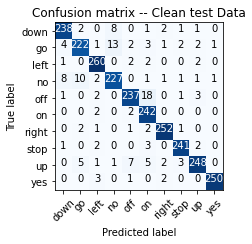

Task B Accuracy =  75.10712894429294 %


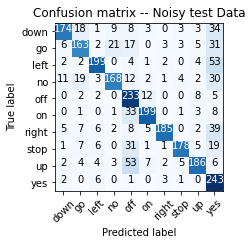

In [41]:
pred_test, pred_testB = return_ypred('trained_GMM_10_mix20_iter20.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '10', '20', '20', 'GMM')

Clean-Train GMM 12-states 15-Mix 10-iter
Task A Accuracy =  93.72808726139462 %


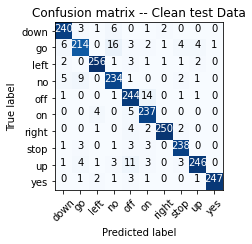

Task B Accuracy =  72.4581223217764 %


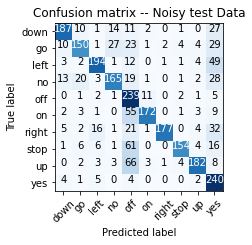

In [42]:
pred_test, pred_testB = return_ypred('trained_GMM_12_mix15_iter10.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '12', '15', '10', 'GMM')

Clean-Train GMM 14-states 15-Mix 10-iter
Task A Accuracy =  93.29957148422284 %


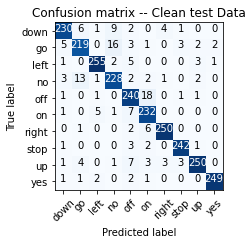

Task B Accuracy =  75.22399688352162 %


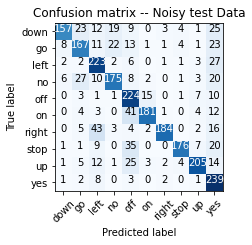

In [43]:
pred_test, pred_testB = return_ypred('trained_GMM_14_mix15_iter10.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '14', '15', '10', 'GMM')

Clean-Train GMM 16-states 10-Mix 10-iter
Task A Accuracy =  93.33852746396572 %


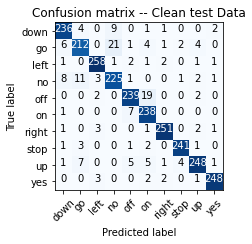

Task B Accuracy =  74.01636151149201 %


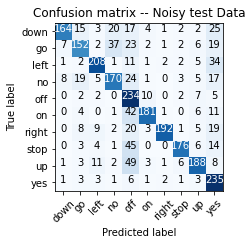

In [44]:
pred_test, pred_testB = return_ypred('trained_GMM_16_mix10.pkl')
accuracy_cm(pred_test, pred_testB, 'Clean', '16', '10', '10', 'GMM')

Clean-Train Gaussian 10-states No-Mix 10-iter
Task A Accuracy =  85.15777171795871 %


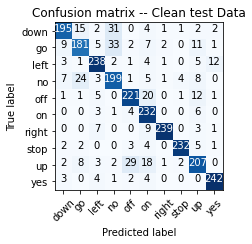

Task B Accuracy =  61.044020257109466 %


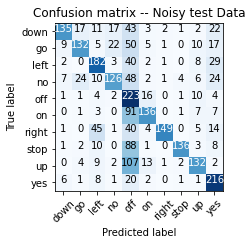

In [45]:
pred_test, pred_testB = return_ypred('trained_Gau_10')
accuracy_cm(pred_test, pred_testB, 'Clean', '10', 'No', '10', 'Gaussian')

Clean-Train Gaussian 10-states No-Mix 20-iter
Task A Accuracy =  84.02804830541488 %


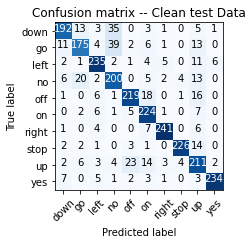

Task B Accuracy =  61.862095831710164 %


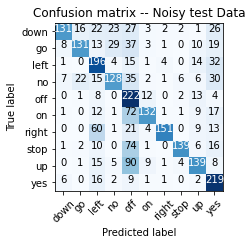

In [46]:
pred_test, pred_testB = return_ypred('trained_Gau_10_iter20')
accuracy_cm(pred_test, pred_testB, 'Clean', '10', 'No', '20', 'Gaussian')

### For Pink Noise overlapped train data

Pink-Train GMM 6-states 15-Mix 10-iter
Task A Accuracy =  66.41994546162836 %


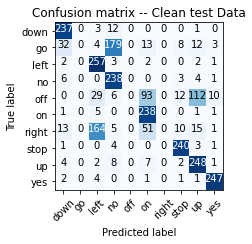

Task B Accuracy =  54.460459680560966 %


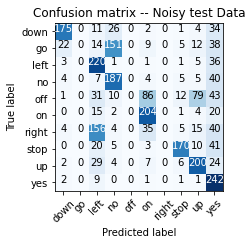

In [47]:
pred_test, pred_testB = return_ypred('trained_GMM_6_pink_mix15.pkl')
accuracy_cm(pred_test, pred_testB, 'Pink', '6', '15', '10', 'GMM')

Pink-Train Gaussian 10-states No-Mix 10-iter
Task A Accuracy =  62.05687573042462 %


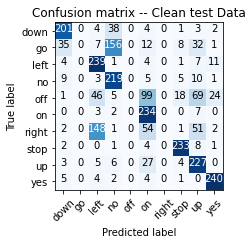

Task B Accuracy =  46.78613167121153 %


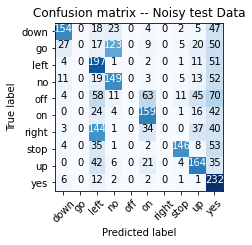

In [48]:
pred_test, pred_testB = return_ypred('trained_Gau_10_pink')
accuracy_cm(pred_test, pred_testB, 'Pink', '10', 'No', '10', 'Gaussian')

### For White noise overlapped Train Data

White-Train GMM 6-states 1-Mix 10-iter
Task A Accuracy =  80.2493182703545 %


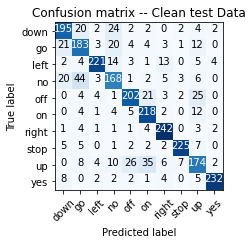

Task B Accuracy =  56.758862485391504 %


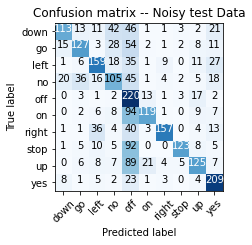

In [49]:
pred_test, pred_testB = return_ypred('trained_GMM_6_white.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '6', '1', '10', 'GMM')

White-Train GMM 6-states 5-Mix 10-iter
Task A Accuracy =  89.52084144916245 %


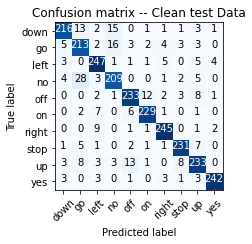

Task B Accuracy =  66.06934164394235 %


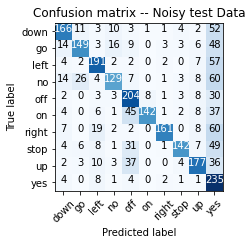

In [50]:
pred_test, pred_testB = return_ypred('trained_GMM_6_white_mix5.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '6', '5', '10', 'GMM')

White-Train GMM 6-states 10-Mix 10-iter
Task A Accuracy =  91.27386053759253 %


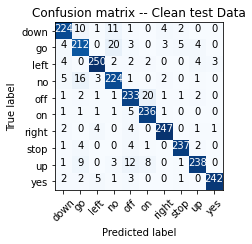

Task B Accuracy =  70.54927931437476 %


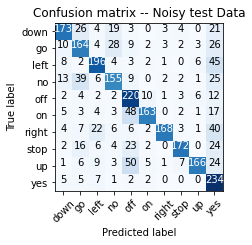

In [51]:
pred_test, pred_testB = return_ypred('trained_GMM_6_white_mix10.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '6', '10', '10', 'GMM')

White-Train GMM 6-states 15-Mix 10-iter
Task A Accuracy =  92.40358395013635 %


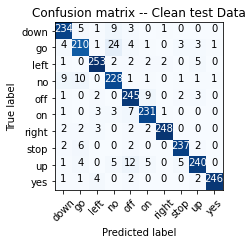

Task B Accuracy =  71.28944292948968 %


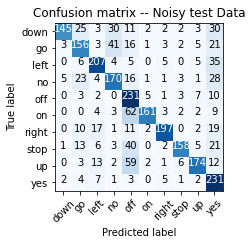

In [52]:
pred_test, pred_testB = return_ypred('trained_GMM_6_white_mix15.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '6', '15', '10', 'GMM')

Streaming output truncated to the last 5000 lines.
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture covariance
Degenerate mixture 

White-Train GMM 6-states 20-Mix 20-iter
Task A Accuracy =  92.83209972730813 %


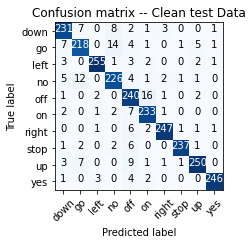

Task B Accuracy =  71.79587066614725 %


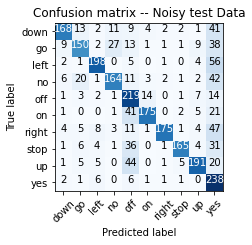

In [53]:
pred_test, pred_testB = return_ypred('trained_GMM_6_white_mix20_iter20.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '6', '20', '20', 'GMM')

White-Train GMM 10-states 20-Mix 20-iter
Task A Accuracy =  94.6240747954811 %


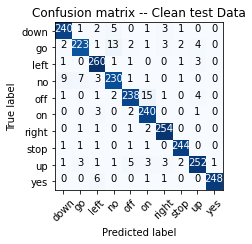

Task B Accuracy =  74.60070120763537 %


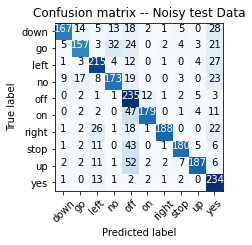

In [54]:
pred_test, pred_testB = return_ypred('trained_GMM_10_white_mix20_iter20.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '10', '20', '20', 'GMM')

White-Train GMM 12-states 15-Mix 10-iter
Task A Accuracy =  93.88391118036618 %


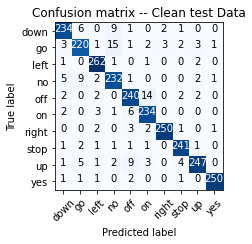

Task B Accuracy =  73.12037397740554 %


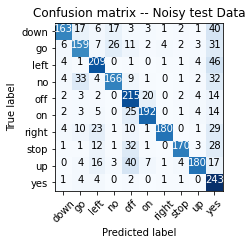

In [55]:
pred_test, pred_testB = return_ypred('trained_GMM_12_white_mix15.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '12', '15', '10', 'GMM')

White-Train GMM 14-states 15-Mix 10-iter
Task A Accuracy =  94.00077911959485 %


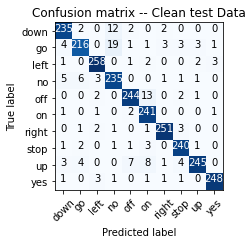

Task B Accuracy =  72.18543046357617 %


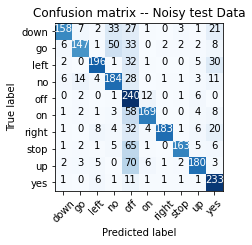

In [56]:
pred_test, pred_testB = return_ypred('trained_GMM_14_white_mix15.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '14', '15', '10', 'GMM')

White-Train Gaussian 6-states No-Mix 10-iter
Task A Accuracy =  80.17140631086872 %


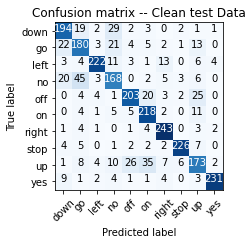

Task B Accuracy =  56.95364238410596 %


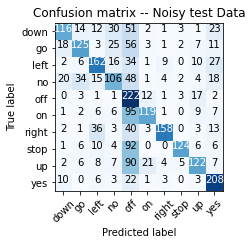

In [57]:
pred_test, pred_testB = return_ypred('trained_Gau_6_white.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '6', 'No', '10', 'Gaussian')

White-Train Gaussian 10-states No-Mix 10-iter
Task A Accuracy =  84.69029996104402 %


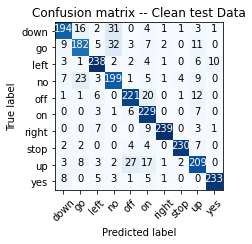

Task B Accuracy =  60.65446045968056 %


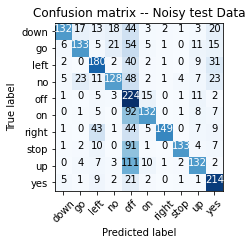

In [58]:
pred_test, pred_testB = return_ypred('trained_Gau_10_white.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '10', 'No', '10', 'Gaussian')

White-Train Gaussian 10-states No-Mix 20-iter
Task A Accuracy =  83.91118036618622 %


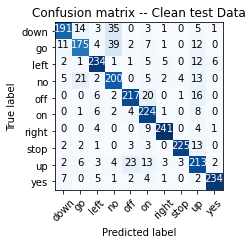

Task B Accuracy =  61.862095831710164 %


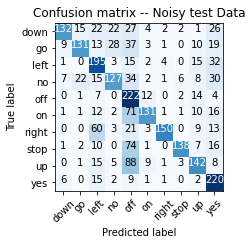

In [61]:
pred_test, pred_testB = return_ypred('trained_Gau_10_white_iter20.pkl')
accuracy_cm(pred_test, pred_testB, 'White', '10', 'No', '20', 'Gaussian')

### Best Accuracies
- Task A = 94.624 (GMM, 10 states, 20 mixtures, 20 iterations, white noised train data)
- Task B = 75.22 (GMM, 14 states, 15 mixtures, 10 iterations, clean train data)